# Lecture 8 — Nearest Neighbours (single use case)

**Single running example:** *item-based recommendation* on a mini “Netflix” table.  
We focus on **user Miley** and recommend **top-$N$ similar items** (nearest neighbours) to the items she already likes.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Callable, Dict, List, Tuple, Optional

np.random.seed(42)

# Pretty printing
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)


## Nearest Neighbours: the problem (adapted to recommendation)

In the lecture, k-NN assigns a **label** to an unknown point using the majority label of its **$k$ nearest neighbours**.

In **item-based recommendation**, we use the same idea but with *items* as points:

- **Each item (movie)** is a point in a feature space.
- A natural feature representation is its **rating vector over users**.
- For Miley, we want the **top-$N$ most similar items** to the items she already likes (or to a target item such as *Joker*).


In [2]:
# Mini “Netflix” user–item rating table (same context as the recommender lecture)
users = ["Lee", "Sofia", "Miley", "Justina", "Donald", "Mickey", "Tristan"]

ratings = pd.DataFrame(
    {
        "Life is Beautiful":  [2.5, 3.0, 2.5, np.nan, 3.0, 3.0, np.nan],
        "Seven Samurai":      [3.5, 3.5, 3.0, 3.5,   4.0, 4.0, 4.5],
        "Joker":              [3.0, 1.5, np.nan, 3.0, 2.0, np.nan, np.nan],
        "Schindler's List":   [3.5, 5.0, 3.5, 4.0,   3.0, 5.0, 4.0],
        "The Pianist":        [3.0, 3.0, 4.0, 4.5,   3.0, 3.0, np.nan],
        "City Of God":        [2.5, 3.5, np.nan, 3.0, 2.0, 3.5, 1.0],
    },
    index=users
)

ratings


,Life is Beautiful,Seven Samurai,Joker,Schindler's List,The Pianist,City Of God
Lee,2.5,3.5,3.0,3.5,3.0,2.5
Sofia,3.0,3.5,1.5,5.0,3.0,3.5
Miley,2.5,3.0,NaN,3.5,4.0,NaN
Justina,NaN,3.5,3.0,4.0,4.5,3.0
Donald,3.0,4.0,2.0,3.0,3.0,2.0
Mickey,3.0,4.0,NaN,5.0,3.0,3.5
Tristan,NaN,4.5,NaN,4.0,NaN,1.0


## Key idea and “lazy learning” (item view)

We treat **each movie** as a stored “case”:

- **Feature vector for a movie** $i$ is its ratings over users:  
  $\mathbf{x}_i = [r_{1,i}, r_{2,i}, \dots, r_{U,i}]$
- “Training” is just **storing the cases** (no model fitting).
- Computation happens at query time: compute distances/similarities and retrieve neighbours.

Below: we visualise movies as points in a **3D user-rating space** using 3 users as axes.


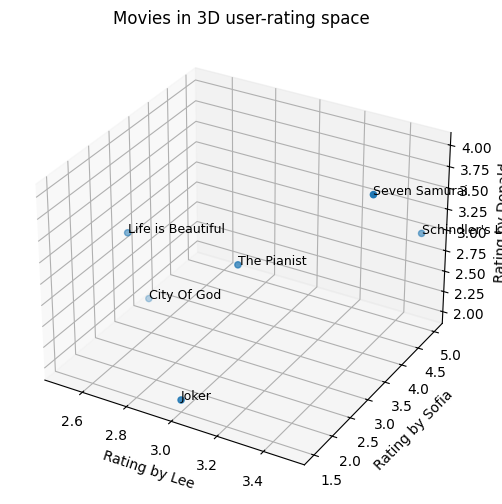

In [3]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_items_in_3d(ratings: pd.DataFrame, users_axes=("Lee", "Sofia", "Donald"), title="Movies in 3D user-rating space"):
    u1, u2, u3 = users_axes
    items = ratings.columns.tolist()

    xs, ys, zs = [], [], []
    for item in items:
        xs.append(ratings.loc[u1, item])
        ys.append(ratings.loc[u2, item])
        zs.append(ratings.loc[u3, item])

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(xs, ys, zs)

    for x, y, z, item in zip(xs, ys, zs, items):
        ax.text(x, y, z, item, fontsize=9)

    ax.set_xlabel(f"Rating by {u1}")
    ax.set_ylabel(f"Rating by {u2}")
    ax.set_zlabel(f"Rating by {u3}")
    ax.set_title(title)
    plt.show()

plot_items_in_3d(ratings)


## k-NN algorithm (adapted)

### Nearest neighbours
The **$k$ nearest neighbours** of a query point $\mathbf{x}$ are the $k$ stored points with the smallest distance:
$
\mathcal{N}_k(\mathbf{x}) = \operatorname{arg\,min}_{k\ \text{points}}\ \mathrm{dist}(\mathbf{x}, \mathbf{x}_i).
$

### From neighbours to a decision (two common outputs)
1) **Classification** (majority vote):  
$
\hat{y}(\mathbf{x}) = \operatorname{mode}\{y_i: i\in\mathcal{N}_k(\mathbf{x})\}.
$

2) **Regression** (weighted average):  
$
\hat{y}(\mathbf{x}) = \frac{\sum_{i\in\mathcal{N}_k(\mathbf{x})} w_i\,y_i}{\sum_{i\in\mathcal{N}_k(\mathbf{x})} w_i}.
$

In our item-based case:

- Query item could be **Joker** (to find similar movies)
- For Miley we can treat each already-rated movie as “labelled”:
  - label = **like** if rating $\ge 3.5$ else **not like**
- Then do **k-NN classification** (“Will Miley like Joker?”) and/or **k-NN regression** (“What rating might she give?”).


In [4]:
import math

def _co_rated_mask(a: pd.Series, b: pd.Series, exclude_user: Optional[str] = None) -> pd.Series:
    mask = a.notna() & b.notna()
    if exclude_user is not None and exclude_user in mask.index:
        mask.loc[exclude_user] = False
    return mask

def euclidean_distance(a: pd.Series, b: pd.Series, exclude_user: Optional[str] = None) -> Tuple[float, int]:
    mask = _co_rated_mask(a, b, exclude_user=exclude_user)
    if mask.sum() == 0:
        return np.inf, 0
    diff = a[mask].values - b[mask].values
    return float(np.sqrt(np.sum(diff**2))), int(mask.sum())

def manhattan_distance(a: pd.Series, b: pd.Series, exclude_user: Optional[str] = None) -> Tuple[float, int]:
    mask = _co_rated_mask(a, b, exclude_user=exclude_user)
    if mask.sum() == 0:
        return np.inf, 0
    diff = np.abs(a[mask].values - b[mask].values)
    return float(np.sum(diff)), int(mask.sum())

def cosine_similarity(a: pd.Series, b: pd.Series, exclude_user: Optional[str] = None) -> Tuple[float, int]:
    mask = _co_rated_mask(a, b, exclude_user=exclude_user)
    if mask.sum() == 0:
        return 0.0, 0
    x = a[mask].values.astype(float)
    y = b[mask].values.astype(float)
    denom = (np.linalg.norm(x) * np.linalg.norm(y))
    if denom == 0:
        return 0.0, int(mask.sum())
    return float(np.dot(x, y) / denom), int(mask.sum())

def pearson_similarity(a: pd.Series, b: pd.Series, exclude_user: Optional[str] = None) -> Tuple[float, int]:
    mask = _co_rated_mask(a, b, exclude_user=exclude_user)
    if mask.sum() < 2:
        return 0.0, int(mask.sum())
    x = a[mask].values.astype(float)
    y = b[mask].values.astype(float)
    x = x - x.mean()
    y = y - y.mean()
    denom = (np.linalg.norm(x) * np.linalg.norm(y))
    if denom == 0:
        return 0.0, int(mask.sum())
    return float(np.dot(x, y) / denom), int(mask.sum())

def top_k_item_neighbours(
    query_item: str,
    ratings: pd.DataFrame,
    k: int = 3,
    metric: str = "pearson",
    min_common: int = 2,
    exclude_user_from_metric: Optional[str] = "Miley",
) -> pd.DataFrame:
    """Return top-k neighbours of `query_item` among all other items.

    metric: 'euclid', 'manhattan', 'cosine', 'pearson'
    - For distance metrics, we return smallest distances.
    - For similarity metrics, we return largest similarities.
    """
    assert query_item in ratings.columns

    query_vec = ratings[query_item]

    rows = []
    for other in ratings.columns:
        if other == query_item:
            continue
        other_vec = ratings[other]

        if metric == "euclid":
            val, n = euclidean_distance(query_vec, other_vec, exclude_user=exclude_user_from_metric)
            score = val
        elif metric == "manhattan":
            val, n = manhattan_distance(query_vec, other_vec, exclude_user=exclude_user_from_metric)
            score = val
        elif metric == "cosine":
            val, n = cosine_similarity(query_vec, other_vec, exclude_user=exclude_user_from_metric)
            score = val
        elif metric == "pearson":
            val, n = pearson_similarity(query_vec, other_vec, exclude_user=exclude_user_from_metric)
            score = val
        else:
            raise ValueError("Unknown metric")

        rows.append({"item": other, "score": score, "n_common_users": n})

    out = pd.DataFrame(rows)
    out = out[out["n_common_users"] >= min_common].copy()

    if metric in ("euclid", "manhattan"):
        out = out.sort_values(["score", "n_common_users"], ascending=[True, False]).head(k)
        out = out.rename(columns={"score": "distance"})
    else:
        out = out.sort_values(["score", "n_common_users"], ascending=[False, False]).head(k)
        out = out.rename(columns={"score": "similarity"})

    out.reset_index(drop=True, inplace=True)
    return out


## Visualising “nearest neighbours” (movie version)

To mirror the slide’s circles: we project movies into a **2D space** using two users as axes:

- x-axis: rating by **Lee**
- y-axis: rating by **Donald**

Then we can draw a circle whose radius reaches the $k$-th nearest neighbour (in this 2D projection).


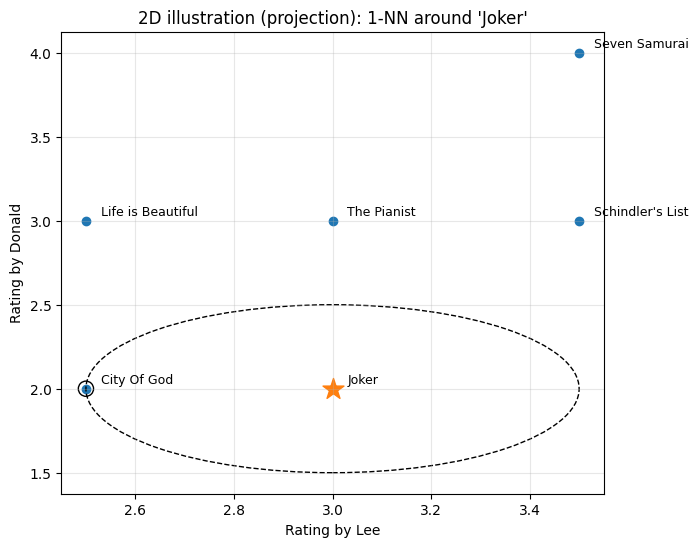

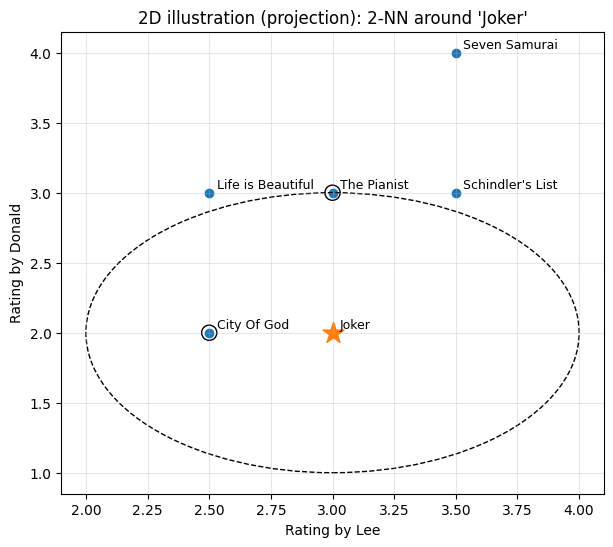

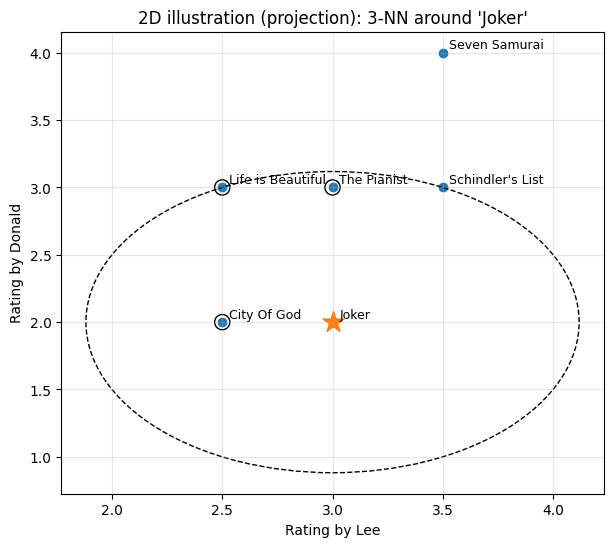

In [5]:
def plot_knn_circles_2d(
    ratings: pd.DataFrame,
    query_item: str = "Joker",
    k: int = 3,
    users_axes=("Lee", "Donald"),
    title_prefix="2D illustration (projection):"
):
    u1, u2 = users_axes

    # coordinates for items (only items with both ratings)
    pts = []
    for item in ratings.columns:
        x = ratings.loc[u1, item]
        y = ratings.loc[u2, item]
        if np.isnan(x) or np.isnan(y):
            continue
        pts.append((item, float(x), float(y)))

    df_pts = pd.DataFrame(pts, columns=["item", u1, u2]).set_index("item")
    assert query_item in df_pts.index, f"{query_item} must have ratings by {u1} and {u2} for this 2D demo."

    q = df_pts.loc[query_item].values
    dists = []
    for item in df_pts.index:
        if item == query_item:
            continue
        p = df_pts.loc[item].values
        d = float(np.linalg.norm(p - q))
        dists.append((item, d))
    dists.sort(key=lambda t: t[1])

    neigh = dists[:k]
    radius = neigh[-1][1] if len(neigh) > 0 else 0.0
    neigh_items = {i for i, _ in neigh}

    plt.figure(figsize=(7, 6))
    plt.scatter(df_pts[u1], df_pts[u2])

    for item in df_pts.index:
        x, y = df_pts.loc[item, u1], df_pts.loc[item, u2]
        if item == query_item:
            plt.scatter([x], [y], marker="*", s=250)
        if item in neigh_items:
            plt.scatter([x], [y], s=120, facecolors="none", edgecolors="black")
        plt.text(x + 0.03, y + 0.03, item, fontsize=9)

    circle = plt.Circle((q[0], q[1]), radius, fill=False, linestyle="--")
    plt.gca().add_patch(circle)

    plt.xlabel(f"Rating by {u1}")
    plt.ylabel(f"Rating by {u2}")
    plt.title(f"{title_prefix} {k}-NN around '{query_item}'")
    plt.grid(True, alpha=0.3)
    plt.show()

for k in [1, 2, 3]:
    plot_knn_circles_2d(ratings, query_item="Joker", k=k)


## Using neighbours to predict for Miley

We now turn k-NN into a recommendation decision.

### Step A: label Miley’s rated movies
We map ratings to a binary preference:

- **like** if rating $\ge 3.5$
- **not like** otherwise

### Step B: for an unseen movie (e.g., *Joker*), find its $k$ nearest neighbour movies *among the movies Miley has rated*  
(using an item–item similarity computed from other users).

### Step C: predict
- **Classification:** majority vote over neighbour labels  
- **Regression:** similarity-weighted average of Miley’s ratings


In [6]:
TARGET_USER = "Miley"
LIKE_THRESHOLD = 3.5

def miley_item_labels(ratings: pd.DataFrame, user: str = "Miley", like_threshold: float = 3.5) -> pd.Series:
    r = ratings.loc[user]
    labels = r.dropna().apply(lambda x: "like" if x >= like_threshold else "not like")
    return labels

labels = miley_item_labels(ratings, TARGET_USER, LIKE_THRESHOLD)
labels


Life is Beautiful    not like
Seven Samurai        not like
Schindler's List         like
The Pianist              like
Name: Miley, dtype: object

### (Recommendation view) Top-$N$ similar items for Miley

A very direct *item-based neighbour* recommendation strategy:

1. Identify items Miley **likes** (rating $\ge 3.5$)  
2. For each liked item, retrieve its **top-$N$ nearest neighbour items**  
3. Recommend neighbour items that Miley **has not rated yet**, ranked by similarity


In [7]:
def recommend_topN_similar_items_for_user(
    user: str,
    ratings: pd.DataFrame,
    like_threshold: float = 3.5,
    N: int = 3,
    sim_metric: str = "cosine",
    min_common: int = 2,
    exclude_user_from_metric: Optional[str] = "Miley",
):
    user_r = ratings.loc[user]
    liked_items = user_r[user_r.notna() & (user_r >= like_threshold)].index.tolist()
    already_rated = set(user_r.dropna().index.tolist())

    recs = []
    for src in liked_items:
        neigh = top_k_item_neighbours(
            query_item=src,
            ratings=ratings,
            k=N,
            metric=sim_metric,
            min_common=min_common,
            exclude_user_from_metric=exclude_user_from_metric,
        )
        # remove items already rated by the user
        if "similarity" in neigh.columns:
            neigh = neigh[~neigh["item"].isin(already_rated)].copy()
            for _, row in neigh.iterrows():
                recs.append({"recommended_item": row["item"], "source_liked_item": src, "similarity": row["similarity"], "n_common_users": row["n_common_users"]})

    if not recs:
        return pd.DataFrame(columns=["recommended_item","source_liked_item","similarity","n_common_users"])

    out = pd.DataFrame(recs).sort_values(["similarity","n_common_users"], ascending=[False, False]).reset_index(drop=True)
    return out

recommendations = recommend_topN_similar_items_for_user("Miley", ratings, like_threshold=LIKE_THRESHOLD, N=3, sim_metric="cosine", min_common=2)
recommendations


,recommended_item,source_liked_item,similarity,n_common_users
0,Joker,The Pianist,0.974893,4
1,City Of God,Schindler's List,0.967284,6


In [8]:
def knn_predict_like(
    user: str,
    target_item: str,
    ratings: pd.DataFrame,
    k: int = 3,
    sim_metric: str = "cosine",
    min_common: int = 2,
    like_threshold: float = 3.5,
    exclude_user_from_metric: Optional[str] = "Miley",
    use_only_positive_sims_for_regression: bool = True,
):
    # items the user has rated (these are the labelled points)
    user_rated = ratings.loc[user].dropna().index.tolist()
    if target_item in user_rated:
        return {"target_item": target_item, "note": "user already rated this item"}

    # compute neighbours of target_item among user's rated items
    neigh_all = top_k_item_neighbours(
        query_item=target_item,
        ratings=ratings[user_rated + [target_item]],
        k=min(k, len(user_rated)),
        metric=sim_metric,
        min_common=min_common,
        exclude_user_from_metric=exclude_user_from_metric,
    )

    # attach user's ratings and labels
    neigh_all["user_rating"] = neigh_all["item"].map(ratings.loc[user].to_dict())
    neigh_all["user_label"] = neigh_all["user_rating"].apply(lambda r: "like" if r >= like_threshold else "not like")

    # classification: majority vote (unweighted)
    pred_label = neigh_all["user_label"].mode().iloc[0] if len(neigh_all) else "unknown"

    # regression: similarity-weighted rating prediction
    pred_rating = np.nan
    if "similarity" in neigh_all.columns and len(neigh_all):
        neigh_for_reg = neigh_all.copy()
        if use_only_positive_sims_for_regression:
            neigh_for_reg = neigh_for_reg[neigh_for_reg["similarity"] > 0].copy()

        if len(neigh_for_reg):
            sims = neigh_for_reg["similarity"].values.astype(float)
            rs = neigh_for_reg["user_rating"].values.astype(float)
            denom = np.sum(np.abs(sims))
            pred_rating = float(np.sum(sims * rs) / denom) if denom > 0 else float(np.mean(rs))
        else:
            # fallback: mean of user's known ratings
            pred_rating = float(ratings.loc[user].dropna().mean())

    return {
        "target_item": target_item,
        "k": k,
        "pred_label": pred_label,
        "pred_rating": pred_rating,
        "neighbours": neigh_all
    }

for item in ["Joker", "City Of God"]:
    out = knn_predict_like(TARGET_USER, item, ratings, k=3, sim_metric="cosine", min_common=2)
    print(f"Target: {item}  -> predicted label = {out['pred_label']}, predicted rating ≈ {out['pred_rating']:.2f}")
    display(out["neighbours"])


Target: Joker  -> predicted label = not like, predicted rating ≈ 3.18


,item,similarity,n_common_users,user_rating,user_label
0,The Pianist,0.974893,4,4.0,like
1,Seven Samurai,0.957621,4,3.0,not like
2,Life is Beautiful,0.936013,3,2.5,not like


Target: City Of God  -> predicted label = like, predicted rating ≈ 3.33


,item,similarity,n_common_users,user_rating,user_label
0,Life is Beautiful,0.978179,4,2.5,not like
1,The Pianist,0.967589,5,4.0,like
2,Schindler's List,0.967284,6,3.5,like


## Choosing $k$ (recommendation version)

The same trade-off holds:

- If $k$ is **too small**: prediction is sensitive to noise / quirks of a single neighbour.
- If $k$ is **too large**: neighbours may include dissimilar items, blurring the decision.

We visualise how Miley’s predicted ratings change as we vary $k$.


In [9]:
def predict_ratings_over_k(
    user: str,
    target_items: List[str],
    ratings: pd.DataFrame,
    k_values: List[int],
    sim_metric: str = "pearson",
    min_common: int = 2
) -> pd.DataFrame:
    rows = []
    for item in target_items:
        for k in k_values:
            out = knn_predict_like(user, item, ratings, k=k, sim_metric=sim_metric, min_common=min_common)
            rows.append({"target_item": item, "k": k, "pred_rating": out["pred_rating"], "pred_label": out["pred_label"]})
    return pd.DataFrame(rows)

k_vals = [1, 2, 3, 4]
preds = predict_ratings_over_k(TARGET_USER, ["Joker", "City Of God"], ratings, k_vals, sim_metric="cosine", min_common=2)
preds


,target_item,k,pred_rating,pred_label
0,Joker,1,4.000000,like
1,Joker,2,3.504469,like
2,Joker,3,3.176706,not like
3,Joker,4,3.255638,like
4,City Of God,1,2.500000,not like
5,City Of God,2,3.245918,like
6,City Of God,3,3.330286,like
7,City Of God,4,3.251074,like


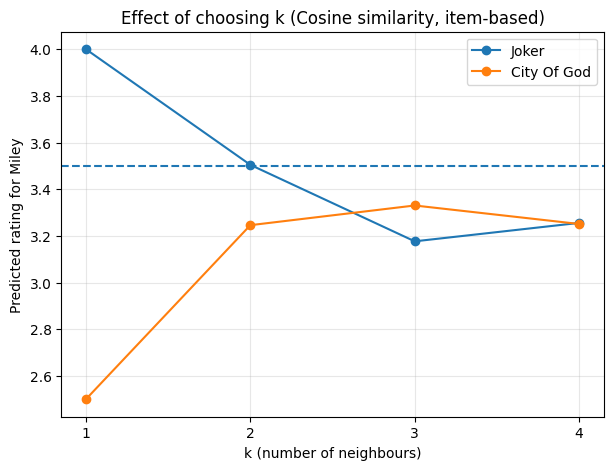

In [10]:
plt.figure(figsize=(7,5))
for item in preds["target_item"].unique():
    sub = preds[preds["target_item"] == item].sort_values("k")
    plt.plot(sub["k"], sub["pred_rating"], marker="o", label=item)

plt.axhline(LIKE_THRESHOLD, linestyle="--")
plt.xticks(k_vals)
plt.xlabel("k (number of neighbours)")
plt.ylabel("Predicted rating for Miley")
plt.title("Effect of choosing k (Cosine similarity, item-based)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Slides 8–12 — Worked example (replaced with Miley + movies)

The slides use a 2D “sweetness vs buttery” plot.  
Here we use a 2D projection in **Lee-vs-Donald rating space** and color points by Miley’s preference label (like / not like).

We then compare the decision region for different $k$ values.


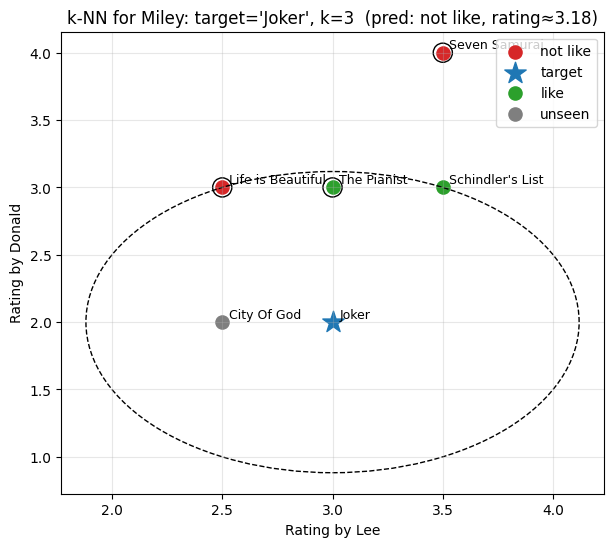

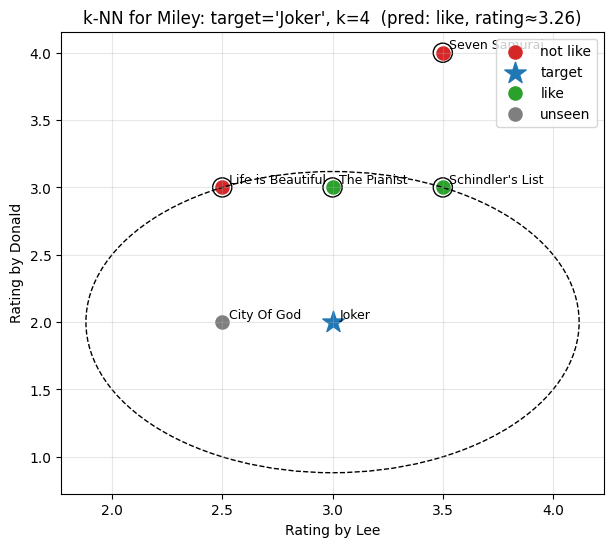

In [11]:
def plot_2d_preference_and_knn(
    ratings: pd.DataFrame,
    user: str = "Miley",
    target_item: str = "Joker",
    k: int = 3,
    users_axes=("Lee", "Donald"),
    like_threshold: float = 3.5
):
    u1, u2 = users_axes

    # items with both axis-ratings
    items = []
    for item in ratings.columns:
        if np.isnan(ratings.loc[u1, item]) or np.isnan(ratings.loc[u2, item]):
            continue
        items.append(item)

    # Miley labels (only for items she rated)
    miley_r = ratings.loc[user]
    label_map = {}
    for item in items:
        if not np.isnan(miley_r[item]):
            label_map[item] = "like" if miley_r[item] >= like_threshold else "not like"
        else:
            label_map[item] = "unseen"

    # Compute neighbours of the target among Miley-rated items (using item–item similarity from other users)
    pred = knn_predict_like(user, target_item, ratings, k=k, sim_metric="cosine", min_common=2)
    neigh_items = set(pred["neighbours"]["item"].tolist()) if "neighbours" in pred else set()

    # Colour palette (kept simple to match slide-like visuals)
    colors = {"like": "tab:green", "not like": "tab:red", "unseen": "tab:gray"}

    plt.figure(figsize=(7,6))
    for item in items:
        x, y = float(ratings.loc[u1, item]), float(ratings.loc[u2, item])
        lab = label_map[item]

        if item == target_item:
            plt.scatter([x],[y], marker="*", s=260, color="tab:blue", label="target" if "target" not in plt.gca().get_legend_handles_labels()[1] else "")
        else:
            plt.scatter([x],[y], s=90, color=colors[lab], label=lab if lab not in plt.gca().get_legend_handles_labels()[1] else "")

        if item in neigh_items:
            plt.scatter([x],[y], s=190, facecolors="none", edgecolors="black")

        plt.text(x+0.03, y+0.03, item, fontsize=9)

    # Circle radius in the 2D projection (purely illustrative, mirrors the slide)
    q = np.array([ratings.loc[u1, target_item], ratings.loc[u2, target_item]], dtype=float)
    d2 = []
    for item in items:
        if item == target_item:
            continue
        p = np.array([ratings.loc[u1, item], ratings.loc[u2, item]], dtype=float)
        d2.append((item, float(np.linalg.norm(p - q))))
    d2.sort(key=lambda t: t[1])
    if len(d2) >= k:
        radius = d2[k-1][1]
        plt.gca().add_patch(plt.Circle((q[0], q[1]), radius, fill=False, linestyle="--"))

    plt.xlabel(f"Rating by {u1}")
    plt.ylabel(f"Rating by {u2}")
    plt.title(f"k-NN for Miley: target='{target_item}', k={k}  (pred: {pred['pred_label']}, rating≈{pred['pred_rating']:.2f})")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_2d_preference_and_knn(ratings, user="Miley", target_item="Joker", k=3)
plot_2d_preference_and_knn(ratings, user="Miley", target_item="Joker", k=4)


## Weighted k-NN (distance weighting)

The slides show three weighting schemes based on distance $\mathrm{dist}$:

1) **Inverse weighting**  
$
w = \frac{1}{\mathrm{dist} + c}
$

2) **Subtraction weighting**  
$
w = \max(0,\ c-\mathrm{dist})
$

3) **Gaussian weighting**  
$
w = \exp\Bigl(-\frac{\mathrm{dist}^2}{c^2}\Bigr)
$

We plot these weight curves and then use them to do a **distance-weighted rating prediction** for Miley.


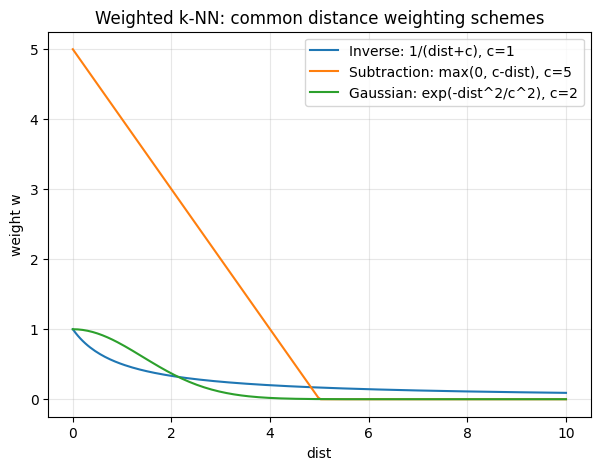

In [12]:
def w_inverse(dist, c=1.0):
    return 1.0 / (dist + c)

def w_subtraction(dist, c=5.0):
    return np.maximum(0.0, c - dist)

def w_gaussian(dist, c=2.0):
    return np.exp(-(dist**2) / (c**2))

d = np.linspace(0, 10, 200)

plt.figure(figsize=(7,5))
plt.plot(d, w_inverse(d, c=1.0), label="Inverse: 1/(dist+c), c=1")
plt.plot(d, w_subtraction(d, c=5.0), label="Subtraction: max(0, c-dist), c=5")
plt.plot(d, w_gaussian(d, c=2.0), label="Gaussian: exp(-dist^2/c^2), c=2")
plt.xlabel("dist")
plt.ylabel("weight w")
plt.title("Weighted k-NN: common distance weighting schemes")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [13]:
def predict_item_based_distance_weighted(
    user: str,
    target_item: str,
    ratings: pd.DataFrame,
    k: int = 3,
    dist_func: Callable[[pd.Series, pd.Series, Optional[str]], Tuple[float, int]] = euclidean_distance,
    weight_func: Callable[[np.ndarray], np.ndarray] = None,
    weight_param_c: float = 1.0,
    min_common: int = 2,
    exclude_user_from_metric: Optional[str] = "Miley",
):
    # Candidate neighbours are the items the user rated
    user_rated_items = ratings.loc[user].dropna().index.tolist()
    if target_item in user_rated_items:
        return np.nan, pd.DataFrame()

    # Compute distances from target item to each rated neighbour item
    rows = []
    for neigh_item in user_rated_items:
        d, n = dist_func(ratings[target_item], ratings[neigh_item], exclude_user=exclude_user_from_metric)
        if n >= min_common and np.isfinite(d):
            rows.append({"item": neigh_item, "distance": d, "n_common_users": n, "user_rating": float(ratings.loc[user, neigh_item])})
    neigh = pd.DataFrame(rows).sort_values(["distance", "n_common_users"], ascending=[True, False]).head(k).reset_index(drop=True)
    if len(neigh) == 0:
        return np.nan, neigh

    if weight_func is None:
        # unweighted average
        pred = float(neigh["user_rating"].mean())
        neigh["weight"] = 1.0
        return pred, neigh

    dist_arr = neigh["distance"].values.astype(float)
    # wrap weight func with c if needed
    if weight_func == w_inverse:
        w = w_inverse(dist_arr, c=weight_param_c)
    elif weight_func == w_subtraction:
        w = w_subtraction(dist_arr, c=weight_param_c)
    elif weight_func == w_gaussian:
        w = w_gaussian(dist_arr, c=weight_param_c)
    else:
        w = weight_func(dist_arr)

    neigh["weight"] = w
    denom = np.sum(w)
    pred = float(np.sum(w * neigh["user_rating"].values) / denom) if denom > 0 else float(neigh["user_rating"].mean())
    return pred, neigh

targets = ["Joker", "City Of God"]
rows = []
for t in targets:
    for name, wf, c in [
        ("Unweighted (mean)", None, 1.0),
        ("Inverse", w_inverse, 1.0),
        ("Subtraction", w_subtraction, 5.0),
        ("Gaussian", w_gaussian, 2.0),
    ]:
        pred, neigh = predict_item_based_distance_weighted(
            user="Miley",
            target_item=t,
            ratings=ratings,
            k=3,
            dist_func=euclidean_distance,
            weight_func=wf,
            weight_param_c=c,
            min_common=2,
            exclude_user_from_metric="Miley",
        )
        rows.append({"target_item": t, "scheme": name, "pred_rating": pred})

pd.DataFrame(rows).pivot(index="target_item", columns="scheme", values="pred_rating")


scheme,Gaussian,Inverse,Subtraction,Unweighted (mean)
target_item,,,,
City Of God,3.030165,3.211515,3.205019,3.333333
Joker,3.056275,3.138224,3.138553,3.166667


## Advantages, issues, and selecting hyperparameters

**Advantages**
- No assumptions about data distribution
- No explicit training phase (“lazy”)
- Simple to implement

**Common issues**
- Computationally expensive for large datasets
- Sensitive to the choice of distance metric and feature scaling
- Performance depends on choosing a good $k$ and weighting scheme

In practice we often use **cross-validation** to select $k$ (and a weighting scheme).
Below we run a tiny *leave-one-out* check on Miley’s known ratings (illustrative; dataset is very small).


In [14]:
def loo_mae_for_miley(
    ratings: pd.DataFrame,
    k_values: List[int],
    sim_metric: str = "cosine",
    min_common: int = 2,
):
    miley_items = ratings.loc["Miley"].dropna().index.tolist()
    rows = []
    for k in k_values:
        errors = []
        for heldout in miley_items:
            # copy and hide one rating
            r2 = ratings.copy()
            true = r2.loc["Miley", heldout]
            r2.loc["Miley", heldout] = np.nan

            # predict heldout using remaining Miley-rated items
            out = knn_predict_like(
                user="Miley",
                target_item=heldout,
                ratings=r2,
                k=k,
                sim_metric=sim_metric,
                min_common=min_common,
                exclude_user_from_metric="Miley"
            )
            pred = out["pred_rating"]
            if not np.isnan(pred):
                errors.append(abs(pred - true))
        mae = float(np.mean(errors)) if errors else np.nan
        rows.append({"k": k, "MAE": mae, "n_tests": len(miley_items)})
    return pd.DataFrame(rows)

cv_res = loo_mae_for_miley(ratings, k_values=[1,2,3], sim_metric="cosine", min_common=2)
cv_res


,k,MAE,n_tests
0,1,0.875000,4
1,2,0.751954,4
2,3,0.667813,4


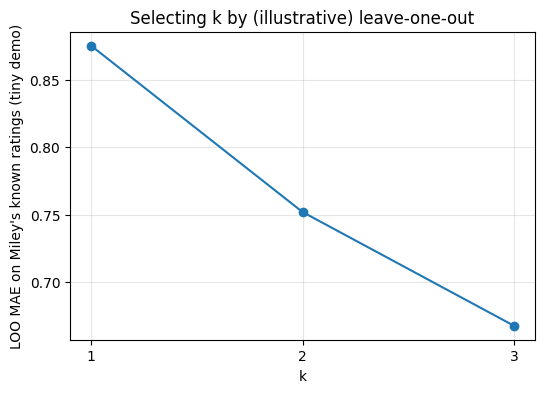

In [15]:
plt.figure(figsize=(6,4))
plt.plot(cv_res["k"], cv_res["MAE"], marker="o")
plt.xticks(cv_res["k"])
plt.xlabel("k")
plt.ylabel("LOO MAE on Miley's known ratings (tiny demo)")
plt.title("Selecting k by (illustrative) leave-one-out")
plt.grid(True, alpha=0.3)
plt.show()


## Curse of dimensionality (movie-rating space)

In item-based CF, each movie lives in a space with **one dimension per user**.  
As the number of users grows, distances become less informative.

A classic illustration: for $k$ neighbours among $N$ points in a unit hypercube, the expected **side length** of the neighbourhood is
$
\ell(D) = \left(\frac{k}{N}\right)^{1/D}.
$

As $D\to\infty$, $\ell(D)\to 1$ (you must cover almost the whole space to capture $k$ neighbours).


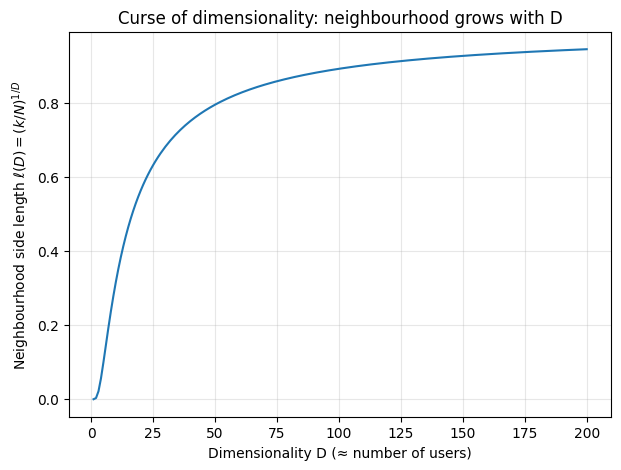

Example values:
D=  1 -> side length ≈ 0.000
D=  2 -> side length ≈ 0.003
D=  3 -> side length ≈ 0.022
D= 10 -> side length ≈ 0.316
D= 50 -> side length ≈ 0.794
D=200 -> side length ≈ 0.944


In [16]:
def neighbourhood_side_length(k: int, N: int, D: int) -> float:
    return (k / N) ** (1.0 / D)

k = 10
N = 1_000_000
Ds = np.arange(1, 201)

L = np.array([neighbourhood_side_length(k, N, int(d)) for d in Ds])

plt.figure(figsize=(7,5))
plt.plot(Ds, L)
plt.xlabel("Dimensionality D (≈ number of users)")
plt.ylabel(r"Neighbourhood side length $\ell(D)=(k/N)^{1/D}$")
plt.title("Curse of dimensionality: neighbourhood grows with D")
plt.grid(True, alpha=0.3)
plt.show()

print("Example values:")
for d in [1, 2, 3, 10, 50, 200]:
    print(f"D={d:3d} -> side length ≈ {neighbourhood_side_length(k,N,d):.3f}")


### Dimensionality reduction 

One common mitigation is to reduce dimensionality for *visualisation* or for approximate neighbour search.

Below we use **PCA** to project movies into 2D (using all users’ ratings with simple imputation).


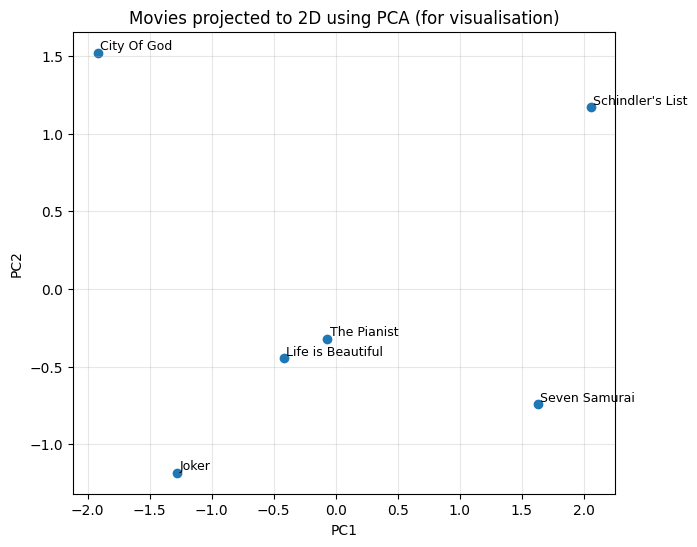

In [17]:
from sklearn.decomposition import PCA

def pca_2d_items(ratings: pd.DataFrame, fill_strategy: str = "item_mean") -> pd.DataFrame:
    X = ratings.T.copy()  # items x users

    if fill_strategy == "item_mean":
        X = X.apply(lambda col: col.fillna(col.mean()), axis=0)
        X = X.fillna(X.mean())  # any remaining
    elif fill_strategy == "zero":
        X = X.fillna(0.0)
    else:
        raise ValueError("Unknown fill_strategy")

    coords = PCA(n_components=2, random_state=42).fit_transform(X.values)
    out = pd.DataFrame(coords, index=X.index, columns=["PC1", "PC2"])
    return out

coords = pca_2d_items(ratings, fill_strategy="item_mean")

plt.figure(figsize=(7,6))
plt.scatter(coords["PC1"], coords["PC2"])
for item in coords.index:
    x, y = coords.loc[item, "PC1"], coords.loc[item, "PC2"]
    plt.text(x+0.02, y+0.02, item, fontsize=9)
plt.title("Movies projected to 2D using PCA (for visualisation)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.show()


## Heterogeneous features: normalisation (ratings)

In recommender data, different users can use rating scales differently (some rate high, others low).  
To reduce this effect, we can normalise each user’s ratings, e.g. **z-score**:
$
z = \frac{x-\mu}{\sigma}
$

Below we compare neighbour rankings for *Joker* using:
- raw ratings
- per-user z-score normalised ratings


In [18]:
def zscore_normalise_by_user(ratings: pd.DataFrame) -> pd.DataFrame:
    R = ratings.copy()
    for u in R.index:
        row = R.loc[u]
        mu = row.mean(skipna=True)
        sigma = row.std(skipna=True)
        if pd.isna(sigma) or sigma == 0:
            sigma = 1.0
        R.loc[u] = (row - mu) / sigma
    return R

ratings_z = zscore_normalise_by_user(ratings)

print("Raw neighbour ranking for Joker (Pearson):")
display(top_k_item_neighbours("Joker", ratings, k=5, metric="pearson", min_common=2, exclude_user_from_metric="Miley"))

print("Z-score normalised neighbour ranking for Joker (Pearson):")
display(top_k_item_neighbours("Joker", ratings_z, k=5, metric="pearson", min_common=2, exclude_user_from_metric="Miley"))


Raw neighbour ranking for Joker (Pearson):


,item,similarity,n_common_users
0,The Pianist,0.555556,4
1,City Of God,-0.258199,4
2,Seven Samurai,-0.333333,4
3,Schindler's List,-0.422890,4
4,Life is Beautiful,-0.944911,3


Z-score normalised neighbour ranking for Joker (Pearson):


,item,similarity,n_common_users
0,Seven Samurai,0.344110,4
1,The Pianist,0.044468,4
2,Schindler's List,-0.069761,4
3,City Of God,-0.705829,4
4,Life is Beautiful,-0.818812,3


## Different distance / similarity metrics (item-based)

The lecture mentions multiple metrics; in recommender settings common choices include:

- Euclidean distance: $\lVert \mathbf{p}-\mathbf{q} \rVert_2$
- Manhattan distance: $\lVert \mathbf{p}-\mathbf{q} \rVert_1$
- Cosine similarity
- Pearson correlation

We compare the **top-3 neighbours of Joker** under these metrics.


In [19]:
comparisons = []
for metric in ["euclid", "manhattan", "cosine", "pearson"]:
    neigh = top_k_item_neighbours("Joker", ratings, k=3, metric=metric, min_common=2, exclude_user_from_metric="Miley")
    neigh["metric"] = metric
    comparisons.append(neigh)

pd.concat(comparisons, axis=0).reset_index(drop=True)


,item,distance,n_common_users,metric,similarity
0,Life is Beautiful,1.870829,3,euclid,NaN
1,City Of God,2.061553,4,euclid,NaN
2,The Pianist,2.345208,4,euclid,NaN
3,City Of God,2.500000,4,manhattan,NaN
4,Life is Beautiful,3.000000,3,manhattan,NaN
5,The Pianist,4.000000,4,manhattan,NaN
6,The Pianist,NaN,4,cosine,0.974893
7,Seven Samurai,NaN,4,cosine,0.957621
8,Life is Beautiful,NaN,3,cosine,0.936013
9,The Pianist,NaN,4,pearson,0.555556


## Scaling to lots of data (quick demo)

For a large catalogue (many items) or many users (high dimensionality), exact neighbour search can be expensive.

Common strategies:
- Index structures (KD-tree / Ball-tree) — work best in lower dimensions
- Hashing / approximate methods
- Breaking up the space

Below we time `NearestNeighbors` with different algorithms on synthetic data.


In [20]:
import time
from sklearn.neighbors import NearestNeighbors

def time_knn_search(n_points=20000, n_dims=10, n_queries=200, k=10):
    X = np.random.rand(n_points, n_dims)
    Q = np.random.rand(n_queries, n_dims)
    algos = ["brute", "kd_tree", "ball_tree"]
    rows = []
    for algo in algos:
        nn = NearestNeighbors(n_neighbors=k, algorithm=algo, metric="euclidean")
        t0 = time.time()
        nn.fit(X)
        fit_t = time.time() - t0

        t0 = time.time()
        nn.kneighbors(Q, return_distance=True)
        query_t = time.time() - t0

        rows.append({"dims": n_dims, "algo": algo, "fit_s": fit_t, "query_s": query_t})
    return pd.DataFrame(rows)

timings = pd.concat([time_knn_search(n_points=10000, n_dims=d, n_queries=200, k=10) for d in [2, 10, 50]], axis=0)
timings


,dims,algo,fit_s,query_s
0,2,brute,0.000236,0.235265
1,2,kd_tree,0.004267,0.001128
2,2,ball_tree,0.002631,0.000814
0,10,brute,0.000173,0.110113
1,10,kd_tree,0.003166,0.013944
2,10,ball_tree,0.003290,0.016165
0,50,brute,0.000340,0.004194
1,50,kd_tree,0.007266,0.097668
2,50,ball_tree,0.009148,0.074045


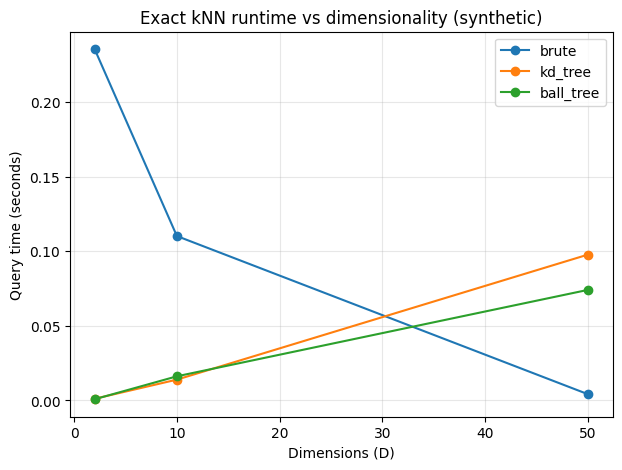

In [21]:
# Plot query time vs dimension (each algorithm)
plt.figure(figsize=(7,5))
for algo in timings["algo"].unique():
    sub = timings[timings["algo"] == algo].sort_values("dims")
    plt.plot(sub["dims"], sub["query_s"], marker="o", label=algo)

plt.xlabel("Dimensions (D)")
plt.ylabel("Query time (seconds)")
plt.title("Exact kNN runtime vs dimensionality (synthetic)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Locality Sensitive Hashing (LSH) for approximate neighbours

**Idea:** build hash codes so that **similar vectors collide** (land in the same bucket) with high probability.

Random-hyperplane LSH for cosine similarity:
- Choose $k$ random hyperplanes $\{\mathbf{h}_1,\dots,\mathbf{h}_k\}$
- Hash a vector $\mathbf{x}$ by the signs of dot products:
$
b_j = \mathbb{1}[\mathbf{h}_j^\top \mathbf{x} \ge 0],\quad \text{code}=b_1b_2\dots b_k
$
- At query time: compare the query only to points in the same bucket (or a few nearby buckets).

Below: a simple LSH demo for finding items similar to *Joker* in a **larger synthetic movie catalogue**.


In [22]:
from collections import defaultdict

def lsh_random_hyperplane_codes(X: np.ndarray, n_bits: int = 12, rng: np.random.Generator = None):
    """Return (codes, hyperplanes) for random-hyperplane LSH (cosine)."""
    if rng is None:
        rng = np.random.default_rng(42)
    D = X.shape[1]
    H = rng.standard_normal(size=(n_bits, D))
    proj = X @ H.T
    bits = (proj >= 0).astype(np.uint8)
    # pack bits into strings for readability
    codes = ["".join(map(str, row.tolist())) for row in bits]
    return np.array(codes), H

def build_buckets(codes: np.ndarray) -> Dict[str, List[int]]:
    buckets = defaultdict(list)
    for idx, code in enumerate(codes):
        buckets[code].append(idx)
    return buckets

def cosine_sim_matrix_one_to_many(q: np.ndarray, X: np.ndarray) -> np.ndarray:
    qn = q / (np.linalg.norm(q) + 1e-12)
    Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
    return (Xn @ qn)

# --- synthetic catalogue: many movies as points in user-rating space
n_movies = 6000
n_users = 60
X = np.random.rand(n_movies, n_users)

# We'll treat index 0 as "Joker-like query" and add a cluster near it
q = np.random.rand(1, n_users)
X[0] = q
X[1:50] = q + 0.02*np.random.randn(49, n_users)  # near neighbours
X = np.clip(X, 0, 1)

# Build LSH
codes, H = lsh_random_hyperplane_codes(X, n_bits=14)
buckets = build_buckets(codes)

query_idx = 0
query_code = codes[query_idx]
cand = buckets[query_code]

# Exact top-k by cosine
k = 10
exact_sims = cosine_sim_matrix_one_to_many(X[query_idx], X)
exact_top = np.argsort(-exact_sims)[:k+1]  # includes self
exact_top = [i for i in exact_top if i != query_idx][:k]

# Approximate: compute cosine only within bucket
cand_sims = cosine_sim_matrix_one_to_many(X[query_idx], X[cand])
cand_order = np.argsort(-cand_sims)
approx_top = [cand[i] for i in cand_order if cand[i] != query_idx][:k]

print(f"LSH bits: 14")
print(f"Bucket size for query: {len(cand)} out of {n_movies} movies")
print(f"Exact top-{k} neighbours overlap with LSH top-{k}: {len(set(exact_top) & set(approx_top))}/{k}")


LSH bits: 14
Bucket size for query: 83 out of 6000 movies
Exact top-10 neighbours overlap with LSH top-10: 10/10


## Summary (aligned to lecture takeaways)

- Nearest neighbours can be used for **classification** and **regression**.
- In recommendation, we use k-NN to retrieve **top-$N$ similar items** and/or to predict ratings by aggregation.
- **Weighted k-NN** often performs better than uniform voting.
- Main limitations:
  - **Scales poorly** with large datasets (many items/users)
  - **Curse of dimensionality** in high-dimensional spaces
  - Sensitive to feature scaling and distance choice
- Common mitigations:
  - **Normalisation**, **dimensionality reduction**
  - Efficient/approximate search (KD-tree / Ball-tree / **LSH**)
